# **Setup**

1. Dependencies Installieren

In [ ]:
%pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

2. Package importieren

In [1]:
#Packung für das Sammeln durch den Webcam
import os, time, uuid, cv2
from pathlib import Path

In [2]:
#Packung für Bilderverarbeitung
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
#Packung für die Ablumentation und die Bildung der Data-Pipeline
import albumentations as alb

In [4]:
#Packung für das Modelbau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [5]:
#Model Speicherung
from tensorflow.keras.models import load_model

# Limit GPU Memory Growth

In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Getting the right PATH

# Bilder labeln



```
!labelme
```

Labelme öffnen, um Ausgangsdaten mit Labels zu versehen, dort wo Gesichter zu sehen sind (nach Akzepentanzkritierien PROJ-71)

Rechteck um das Gesicht, wenn kein Gesicht vorhanden Datei ignorieren

Labels als json in den labels Ordner übertragen

# **3. Die gesamte Datenmenge in kleineren Gruppen aufteilen**

Trennung der data/images Ordner in 3 kleineren Ordnern
```
#training_set
for x in range(int(len(l)*0.7)+1):
  file = l[x]
  EX_PATH = os.path.join("data","images",file)
  NEW_PATH = os.path.join("data","train","images",file)
  os.replace(EX_PATH,NEW_PATH)


#testing_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','images',file)
  NEW_PATH = os.path.join('data','test','images',file)
  os.replace(EX_PATH,NEW_PATH)

#validation_set
for x in range(int(len(l)*0.5)):
  file = l[x]
  EX_PATH = os.path.join('data','test','images',file)
  NEW_PATH = os.path.join('data','val','images',file)
  os.replace(EX_PATH,NEW_PATH)
```



Die passende Label für jedes Bildes in der richtige Ordner anordnen


```
for folder in ['train','test','val']:
  for file in os.listdir(os.path.join('data',folder,'images')):
    filename = file.split('.')[0]+'.json'
    EX_PATH = os.path.join('data','labels',filename)
    if os.path.exists(EX_PATH):
      NEW_PATH = os.path.join('data',folder,'labels',filename)
      os.replace(EX_PATH,NEW_PATH)
```



Image in eine tf data pipeline laden (Beispiel)

In [9]:
images = tf.data.Dataset.list_files(os.path.join('data/train/images/*.jpg'))

In [10]:
images.as_numpy_iterator().next()

b'data\\train\\images\\image56.jpg'

In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img = img/255
    return img

In [12]:
images = images.map(load_image)

In [13]:
images.as_numpy_iterator().next()

array([[[0.1430245 , 0.18224019, 0.18616176],
        [0.14686275, 0.18607843, 0.19      ],
        [0.1506536 , 0.18986928, 0.19379085],
        ...,
        [0.10196079, 0.19215687, 0.24705882],
        [0.10588235, 0.19607843, 0.2509804 ],
        [0.10385617, 0.19405225, 0.2489542 ]],

       [[0.14872548, 0.18794118, 0.19186275],
        [0.14885785, 0.18807353, 0.1919951 ],
        [0.14914216, 0.18835784, 0.19227941],
        ...,
        [0.09470588, 0.19578432, 0.24705882],
        [0.09862745, 0.19970588, 0.2509804 ],
        [0.09660126, 0.1976797 , 0.2489542 ]],

       [[0.15079248, 0.19000818, 0.19392975],
        [0.14901961, 0.1882353 , 0.19215687],
        [0.14901961, 0.1882353 , 0.19215687],
        ...,
        [0.09411765, 0.19607843, 0.24705882],
        [0.09803922, 0.2       , 0.2509804 ],
        [0.09601302, 0.19797382, 0.2489542 ]],

       ...,

       [[0.1218219 , 0.16790032, 0.21752451],
        [0.12605391, 0.17213234, 0.21821079],
        [0.12075163, 0

In [14]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

Image visualisieren 

In [15]:
images_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = images_generator.next()

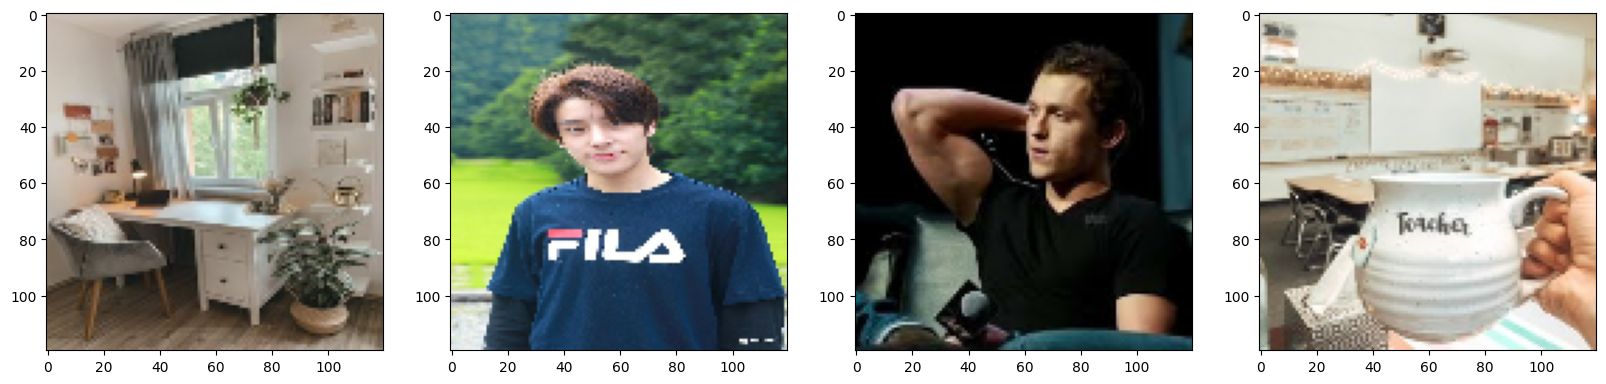

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **4. Albumentation Setting für die Augmentatition den Bildern aufstellen**

In [18]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)], 
                        bbox_params= alb.BboxParams(format="albumentations",label_fields=["class_labels"]))
#alb.RandomCrop(width=500,height=500),

Laden eines Beispielbilds

In [19]:
image_path = "image24"

In [20]:
img = cv2.imread(os.path.join('data','train','images',image_path+".jpg"))

In [21]:
size= img.shape
print(size)

(1200, 914, 3)


In [22]:
with open(os.path.join('data','train','labels',image_path+'.json'),'r') as f:
  label = json.load(f)

In [23]:
label['shapes'][0]['points']

[[139.54430379746827, 54.43037974683544],
 [764.8607594936709, 751.8987341772151]]

Koordinaten Extrahieren und Maßstab ändern

In [24]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [25]:
coords

[139.54430379746827, 54.43037974683544, 764.8607594936709, 751.8987341772151]

In [26]:
coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

In [27]:
coords

[0.15267429299504187,
 0.04535864978902954,
 0.8368279644350886,
 0.6265822784810127]

Augmentation implimentieren

In [32]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [33]:
augmented['bboxes'][0]


(0.15267429299504187,
 0.04535864978902954,
 0.8368279644350886,
 0.6265822784810127)

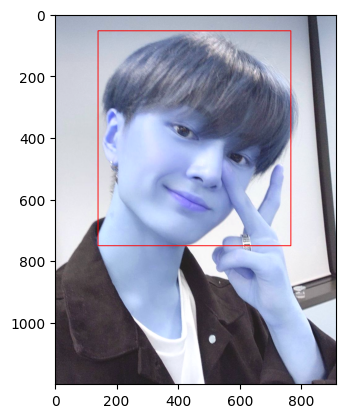

In [34]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [size[1],size[0]]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [size[1],size[0]]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented['image'])

Aug-data Ordner herstellen

In [35]:
for path in ['train','test','val']:
  for folder in ['images','labels']:
   PATH = os.path.join('aug_data',path,folder)
   os.makedirs(PATH)

# **5. Augmentation Pipeline durchführen**

In [36]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        size = img.shape

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords,[size[1],size[0],size[1],size[0]]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.8317323943661973, 0.5497395475629471, 0.5485, 0.0, 'face'].
y_max is less than or equal to y_min for bbox [0.44457068657685445, 0.2988298829882988, 0.6090461505166911, 0.16633663366336635, 'face'].
x_max is less than or equal to x_min for bbox [0.6501111218475215, 0.43881856540084385, 0.24749573227687047, 0.12130801687763712, 'face'].
x_max is less than or equal to x_min for bbox [0.7181190902121134, 0.4221409121851599, 0.3475594173268591, 0.0966643975493533, 'face'].
x_max is less than or equal to x_min for bbox [0.793085246766957, 0.005278437582475587, 0.11638954869358668, 0.8023225125362893, 'face'].
x_max is less than or equal to x_min for bbox [0.587722306910569, 0.6845641373080398, 0.2777629573170732, 0.030770099367660345, 'face'].
x_max is less than or equal to x_min for bbox [0.6308577692518498, 0.07355249204665959, 0.35583134322514964, 0.4128950159066808, 'face'].
x_max is less than or equal to x_min for bbox [0.6925925925925925

## **6.Die Augmented Bildern zu eine Tensorflow Dataset laden**

In [37]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle= False)
train_images = train_images.map(load_image)

In [38]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle= False)
test_images = test_images.map(load_image)

In [39]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle= False)
val_images = val_images.map(load_image)

In [40]:
train_images.as_numpy_iterator().next()

array([[[0.7058824 , 0.6666667 , 0.7019608 ],
        [0.7081967 , 0.668981  , 0.70427513],
        [0.70390624, 0.67645526, 0.7078278 ],
        ...,
        [0.7554259 , 0.75101405, 0.8213572 ],
        [0.788194  , 0.79653776, 0.88387   ],
        [0.82441187, 0.8455756 , 0.9433103 ]],

       [[0.7083928 , 0.6691771 , 0.70447123],
        [0.70980394, 0.67058825, 0.7058824 ],
        [0.7058824 , 0.6784314 , 0.70980394],
        ...,
        [0.78049636, 0.77465993, 0.8494669 ],
        [0.812491  , 0.82381034, 0.91098505],
        [0.83750004, 0.85904795, 0.95876426]],

       [[0.7144455 , 0.6752298 , 0.7105239 ],
        [0.71073836, 0.6715227 , 0.7068168 ],
        [0.7022059 , 0.6747549 , 0.70612746],
        ...,
        [0.8130055 , 0.8163603 , 0.8956801 ],
        [0.8349511 , 0.8535726 , 0.9404936 ],
        [0.8457322 , 0.86998165, 0.9687072 ]],

       ...,

       [[0.812451  , 0.83843136, 0.9318137 ],
        [0.8077696 , 0.8331128 , 0.92497545],
        [0.85261947, 0

Labels vorbereiten

In [41]:
def load_labels(label_path):
  with open(label_path.numpy(),'r', encoding = "utf-8") as f:
    label = json.load(f)
  
  return [label['class']],label['bbox']

In [42]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [43]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [44]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels,[x],[tf.uint8,tf.float16]))

In [45]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2732, 0.4014, 0.779 , 0.944 ], dtype=float16))

# **7. Combine Image and Label Sampels**

7.1 Check Partition Lengths

In [46]:
len(train_images), len(train_labels), len(test_images), len(test_labels),len(val_images), len(val_labels)

(1980, 1980, 300, 300, 540, 540)

7.2 Create Final Dataset (Image/Label)

In [47]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [48]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [49]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [50]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2367 , 0.06647, 0.4763 , 0.309  ],
        [0.299  , 0.6934 , 0.6035 , 0.9473 ],
        [0.351  , 0.4067 , 0.8955 , 0.9844 ],
        [0.2168 , 0.55   , 0.707  , 0.92   ],
        [0.265  , 0.5293 , 0.7437 , 0.887  ],
        [0.452  , 0.585  , 0.6343 , 0.972  ],
        [0.1404 , 0.0845 , 0.495  , 0.513  ],
        [0.378  , 0.518  , 0.762  , 0.8438 ]], dtype=float16))

7.3 View Images and Annotations

In [51]:
data_samples = train.as_numpy_iterator()

In [52]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


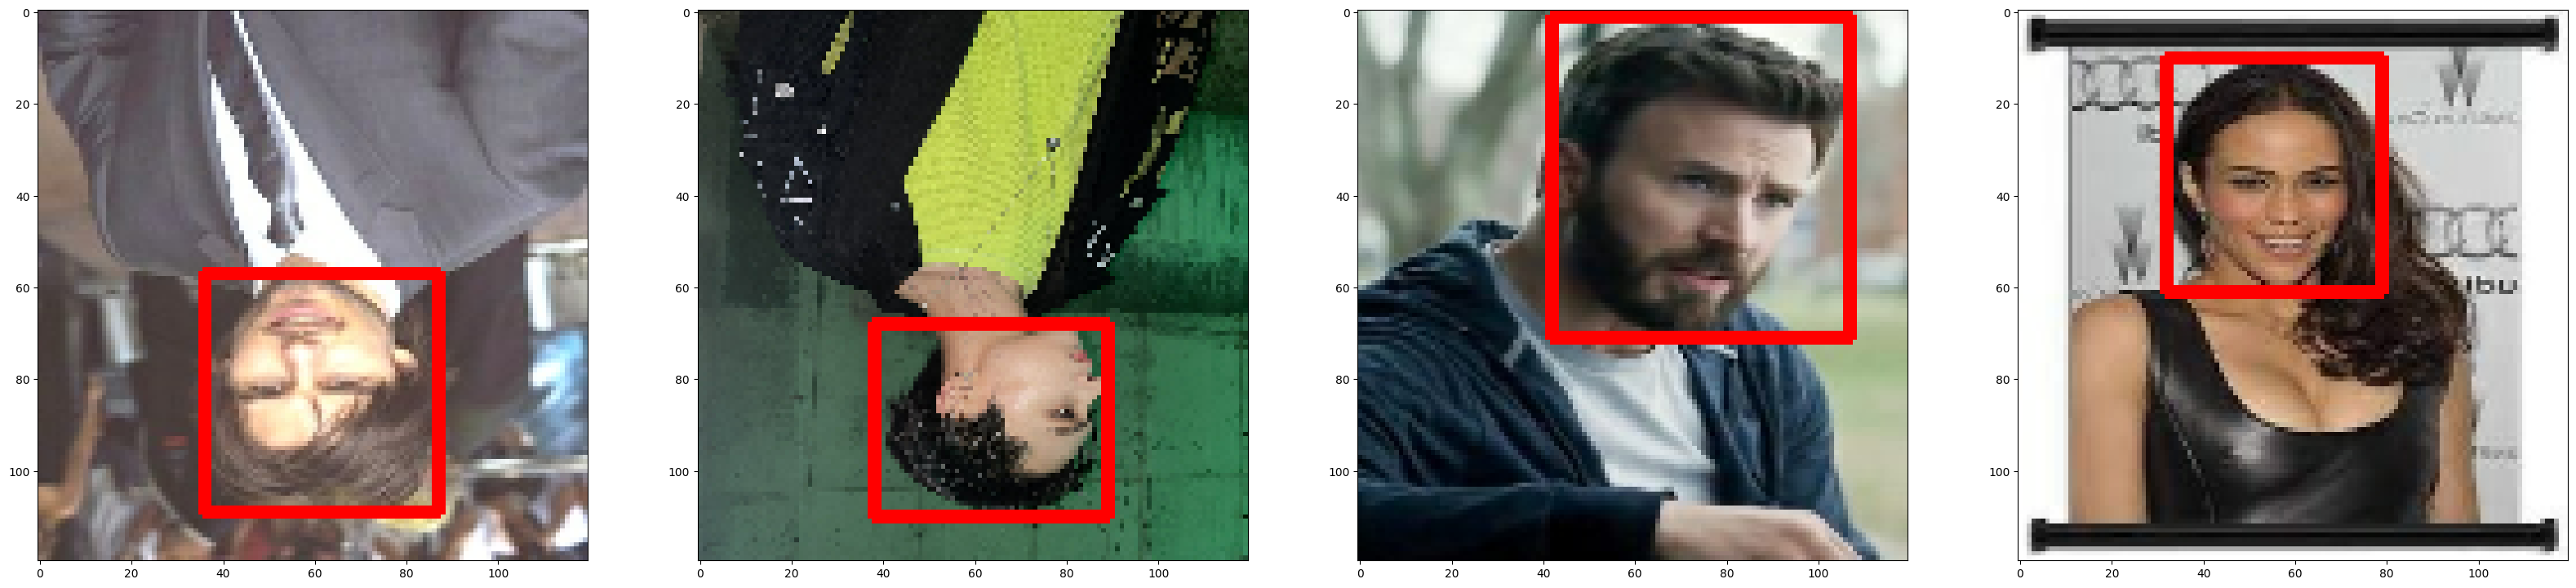

In [53]:
fig, ax = plt.subplots(ncols=4, figsize=(40, 40))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

# **8. Aufbauen des Deep Learning-Modells**

### 8.1 Base Network sowie Layers importieren und VGG16 installieren

In [54]:
vgg = VGG16(include_top=False)

In [55]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Eine Instanz des Neural Networks bauen

In [56]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.3 Testen des Neural Networks

In [57]:
facetracker = build_model()

In [58]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [59]:
X, y = train.as_numpy_iterator().next()

In [60]:
X.shape

(8, 120, 120, 3)

In [61]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 7s 7s/step


In [62]:
classes, coords

(array([[0.4849264 ],
        [0.5064722 ],
        [0.5789906 ],
        [0.6134682 ],
        [0.5207818 ],
        [0.4249936 ],
        [0.51426315],
        [0.4522861 ]], dtype=float32),
 array([[0.32207525, 0.5449906 , 0.47359654, 0.35172263],
        [0.3368402 , 0.48308563, 0.47666532, 0.2306937 ],
        [0.27150413, 0.4324015 , 0.5573628 , 0.39214396],
        [0.37418577, 0.53548247, 0.5588702 , 0.36351812],
        [0.37268683, 0.6054702 , 0.56974006, 0.3025616 ],
        [0.37753436, 0.51555157, 0.6013746 , 0.3334169 ],
        [0.29939044, 0.58945906, 0.566523  , 0.30988723],
        [0.39505997, 0.6047556 , 0.51177335, 0.37624794]], dtype=float32))

# **9.Define Losses and Optimizer**

## 9.1 Define Optimizer

In [63]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/ batches_per_epoch

In [64]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Create Localization Loss and Classification Loss

In [65]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [66]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out Loss Metrics

In [67]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8770332>

In [68]:
classloss(y[0],classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.675713>

In [69]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8770332>

# **10.Train Neural Network**

## 10.1 Create Custom Model Class

In [70]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [71]:
model = FaceTracker(facetracker)

In [72]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [73]:
logdir='logs'

In [74]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [75]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
248/248 [==============================] - 56s 180ms/step - total_loss: 0.1976 - class_loss: 0.0103 - regress_loss: 0.1924 - val_total_loss: 0.0800 - val_class_loss: 1.0938e-05 - val_regress_loss: 0.0800
Epoch 2/10
248/248 [==============================] - 47s 167ms/step - total_loss: 0.0079 - class_loss: 9.3788e-06 - regress_loss: 0.0079 - val_total_loss: 0.1079 - val_class_loss: 2.4290e-05 - val_regress_loss: 0.1078
Epoch 3/10
248/248 [==============================] - 47s 168ms/step - total_loss: 0.0036 - class_loss: 3.4644e-06 - regress_loss: 0.0036 - val_total_loss: 0.0896 - val_class_loss: 7.5401e-06 - val_regress_loss: 0.0896
Epoch 4/10
248/248 [==============================] - 59s 216ms/step - total_loss: 0.0017 - class_loss: 2.0316e-06 - regress_loss: 0.0017 - val_total_loss: 0.0684 - val_class_loss: 1.6689e-06 - val_regress_loss: 0.0684
Epoch 5/10
248/248 [==============================] - 82s 306ms/step - total_loss: 0.0026 - class_loss: 1.4782e-06 - regress_los

## 10.3 Plot Performance

In [76]:
hist.history

{'total_loss': [0.0030585695058107376,
  0.0033748638816177845,
  0.0004412634007167071,
  0.0006542319897562265,
  0.005883713718503714,
  0.0002464093849994242,
  0.00037224218249320984,
  0.0003817092801909894,
  0.0003266751009505242,
  0.0009582821512594819],
 'class_loss': [2.9684711989830248e-05,
  8.55337202665396e-06,
  3.397487944312161e-06,
  3.4272759421583032e-06,
  2.980233659855003e-07,
  1.7881422991194995e-06,
  -0.0,
  -0.0,
  1.2218979463796131e-06,
  -0.0],
 'regress_loss': [0.0030437272507697344,
  0.0033705872483551502,
  0.0004395646683406085,
  0.0006525183562189341,
  0.005883564706891775,
  0.00024551531532779336,
  0.00037224218249320984,
  0.0003817092801909894,
  0.00032606415334157646,
  0.0009582821512594819],
 'val_total_loss': [0.08000239729881287,
  0.10785296559333801,
  0.08959296345710754,
  0.06839248538017273,
  0.06686501204967499,
  0.2844834625720978,
  0.33153030276298523,
  0.14284446835517883,
  0.11114858835935593,
  0.128167062997818],
 'v

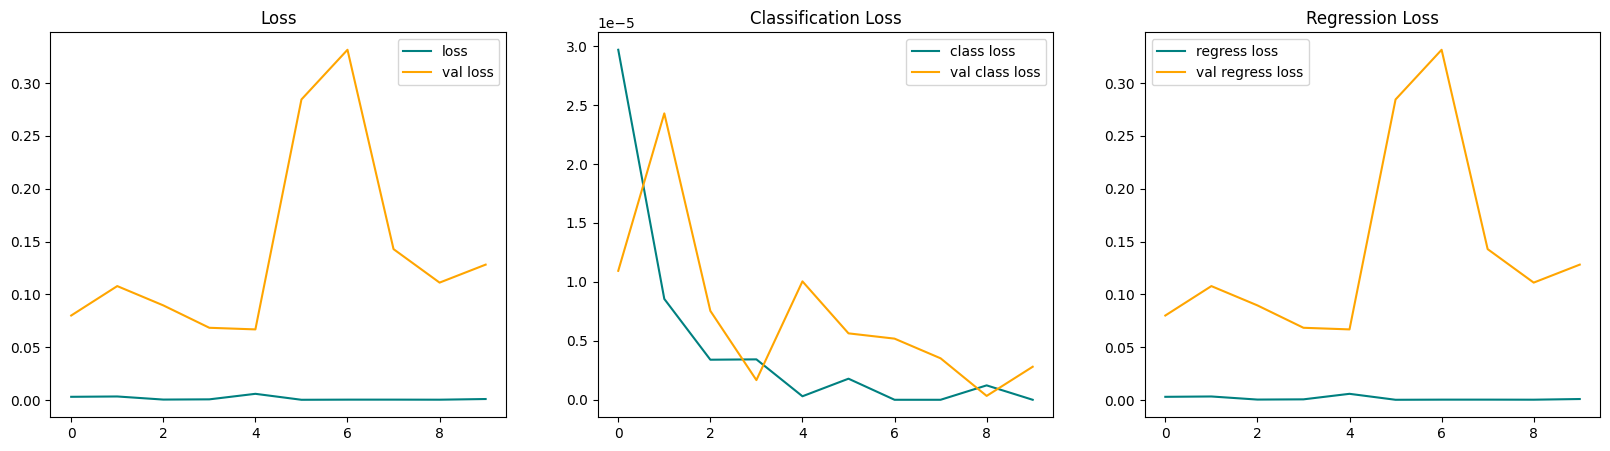

In [77]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# **11. Make Prediction**

## 11.1 Making Prediction on test set for valuation purpose

In [78]:
test_data = test.as_numpy_iterator()

In [93]:
test_sample = test_data.next()

In [94]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


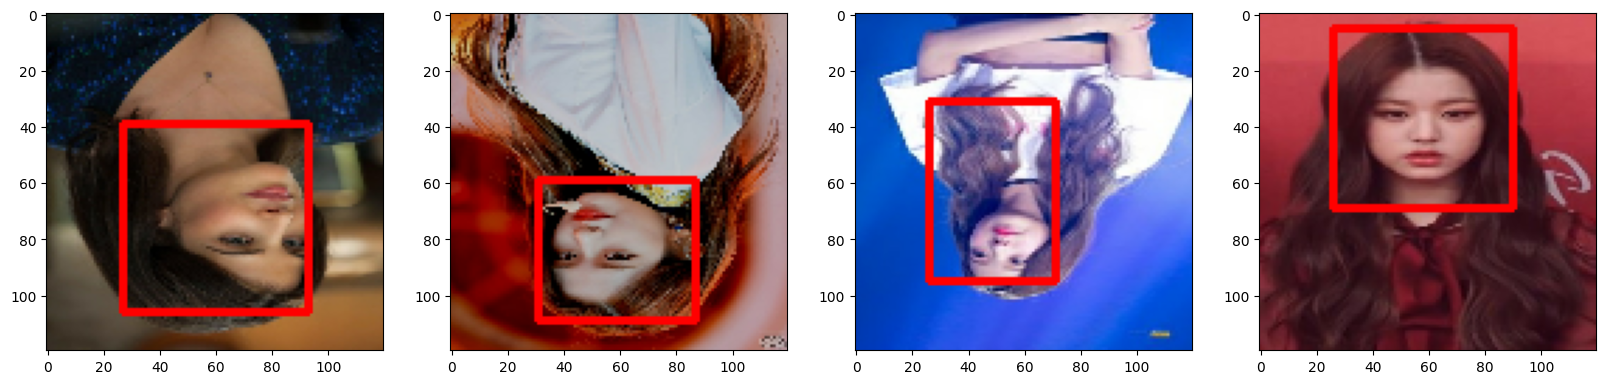

In [95]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [96]:
facetracker.save('facetracker.h5')

In [97]:
facetracker = load_model('facetracker.h5')

## 11.3 Real Time Detection

In [98]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1261: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
